# Imports

In [1]:
import numpy as np
import pandas as pd
import time
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from nltk import classify
from nltk.classify.scikitlearn import SklearnClassifier

# Data

In [2]:
# Database do https://brasil.io/dataset/genero-nomes/nomes/
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

dfData = pd.read_csv('nomes.csv.gz') 
dfData

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0
...,...,...,...,...,...,...,...,...,...
100782,MACILEIA,F,MACLEIA,43.0,NaN,43,457,MACILEIA,1.0
100783,GELINE|GILEINE|GLEINE|GLEINER|GLEYNE|JAELINE|J...,F,GIULINE,24.0,NaN,24,2869,JALINE,1.0
100784,DEMILTOM|DEMILTON,M,DEMAILTON,NaN,24.0,24,631,DEMILTON,1.0
100785,ALIVIA|ELIVIA|EULIVIA|HOLIVIA|LEIVIA|LIIVIA|LI...,F,ILIVIA,22.0,NaN,22,179561,LIVIA,1.0


In [3]:
names = dfData["first_name"].apply(lambda x: x.lower())
classification = dfData['classification']

In [4]:
def prepareData(names, genders):
    dataSet = list()
    for name, gender in zip(names, genders):
        dictName = {}
        for i in range(10):
            if i>=len(name):
                dictName[i] = ""
            else:
                dictName[i] = name[-i]
        dataSet.append((dictName, gender))
    
    return dataSet

In [5]:
data = prepareData(names, classification)

In [6]:
treino, teste = train_test_split(data, test_size=0.2, random_state=28)

# SVM

In [7]:
from sklearn.model_selection import (cross_validate,
                                    learning_curve,
                                    ShuffleSplit)

In [8]:
class SKClassifier(SklearnClassifier):
    def train(self, labeled_featuresets):
        """
        Train (fit) the scikit-learn estimator.

        :param labeled_featuresets: A list of (featureset, label)
            where each featureset is a dict mapping strings to either
            numbers, booleans or strings.
        """

        X, y = list(zip(*labeled_featuresets))
        X = self._vectorizer.fit_transform(X)
        y = self._encoder.fit_transform(y)
        self._clf.fit(X, y)
        cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
        train_sizes, train_scores, test_scores = learning_curve(self._clf, X, y, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

        return self, train_sizes, train_scores, test_scores

            SVC with linear kernel

In [9]:
linearclf = SKClassifier(svm.SVC(kernel="linear", C=10.0))

In [10]:
linearclf, linear_train_sizes, linear_train_scores, linear_test_scores = linearclf.train(treino)

In [65]:
dump((linearclf, linear_train_sizes, linear_train_scores, linear_test_scores),
     r"./results/learning_curve/linear.hdf5")

['./results/learning_curve/linear.hdf5']

            LinearSVC

In [11]:
linearSVCclf = SKClassifier(svm.LinearSVC(C=1.0, max_iter=1000000))

In [12]:
linearSVCclf, linearSVCclf_train_sizes, linearSVCclf_train_scores, linearSVCclf_test_scores = linearSVCclf.train(treino)

In [66]:
dump((linearSVCclf, linearSVCclf_train_sizes, linearSVCclf_train_scores, linearSVCclf_test_scores),
     r"./results/learning_curve/nulinear.hdf5")

['./results/learning_curve/nulinear.hdf5']

            SVC with RBF kernel

In [13]:
rbfclf = SKClassifier(svm.SVC(kernel="rbf", gamma=0.01, C=100.0))

In [14]:
rbfclf, rbfclf_train_sizes, rbfclf_train_scores, rbfclf_test_scores = rbfclf.train(treino)

In [67]:
dump((rbfclf, rbfclf_train_sizes, rbfclf_train_scores, rbfclf_test_scores),
     r"./results/learning_curve/rbf.hdf5")

['./results/learning_curve/rbf.hdf5']

            NuSVC with RBF kernel

In [15]:
nurbfclf = SKClassifier(svm.NuSVC(kernel="rbf", gamma=0.01, nu=0.1))

In [16]:
nurbfclf, nurbfclf_train_sizes, nurbfclf_train_scores, nurbfclf_test_scores = nurbfclf.train(treino)

In [68]:
dump((nurbfclf, nurbfclf_train_sizes, nurbfclf_train_scores, nurbfclf_test_scores),
     r"./results/learning_curve/nurbf.hdf5")

['./results/learning_curve/nurbf.hdf5']

            SVC with Poly kernel

In [17]:
polyclf = SKClassifier(svm.SVC(kernel='poly', gamma='auto', degree=1, C=100.0))

In [18]:
polyclf, polyclf_train_sizes, polyclf_train_scores, polyclf_test_scores = polyclf.train(treino)

In [75]:
dump((polyclf, polyclf_train_sizes, polyclf_train_scores, polyclf_test_scores),
     r"./results/learning_curve/poly.hdf5")

['./results/learning_curve/poly.hdf5']

            NuSVC with Poly kernel

In [19]:
nupolyclf = SKClassifier(svm.NuSVC(kernel='poly', gamma='auto', degree=1, nu=0.3))

In [20]:
nupolyclf, nupolyclf_train_sizes, nupolyclf_train_scores, nupolyclf_test_scores = nupolyclf.train(treino)

In [74]:
dump((nupolyclf, nupolyclf_train_sizes, nupolyclf_train_scores, nupolyclf_test_scores),
     r"./results/learning_curve/nupoly.hdf5")

['./results/learning_curve/nupoly.hdf5']

            SVC with Sigmoid kernel

In [21]:
sigmoidclf = SKClassifier(svm.SVC(kernel='sigmoid', gamma=0.01, C=0.01))

In [22]:
sigmoidclf, sigmoidclf_train_sizes, sigmoidclf_train_scores, sigmoidclf_test_scores = sigmoidclf.train(treino)

In [73]:
dump((sigmoidclf, sigmoidclf_train_sizes, sigmoidclf_train_scores, sigmoidclf_test_scores ),
     r"./results/learning_curve/sigmoid.hdf5")

['./results/learning_curve/sigmoid.hdf5']

            NuSVC with Sigmoid kernel

In [23]:
nusigmoidclf = SKClassifier(svm.NuSVC(kernel='sigmoid', gamma=0.01, nu=0.9))

In [24]:
nusigmoidclf, nusigmoidclf_train_sizes, nusigmoidclf_train_scores, nusigmoidclf_test_scores = nusigmoidclf.train(treino)

In [72]:
dump((nusigmoidclf, nusigmoidclf_train_sizes, nusigmoidclf_train_scores, nusigmoidclf_test_scores),
     r"./results/learning_curve/nusigmoid.hdf5")

['./results/learning_curve/nusigmoid.hdf5']

In [107]:
def plot_learning_curves(train_size, train_scores, test_scores, name_kernel, loc_legend='lower left'):
    title = "Learning Curves"
    ylim=(0.7, 1.01)
    n_jobs=4
    plt.rcParams.update({'font.size': 16})

    plt.figure(figsize=(8, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    for size, train, test, name in zip(train_size, train_scores, test_scores, name_kernel):
        
        train_scores_mean = np.mean(train, axis=1)
        train_scores_std = np.std(train, axis=1)
        test_scores_mean = np.mean(test, axis=1)
        test_scores_std = np.std(test, axis=1)

        train_fill_down = train_scores_mean - train_scores_std
        train_fill_up = train_scores_mean + train_scores_std
        test_fill_down = test_scores_mean - test_scores_std
        test_fill_up = test_scores_mean + test_scores_std

        plt.fill_between(size, train_fill_down, train_fill_up, alpha=0.1)
        plt.fill_between(size, test_fill_down, test_fill_up, alpha=0.1)

        plt.plot(size, train_scores_mean, 'o-',
                 label=f"({name})Training score")
        plt.plot(size, test_scores_mean, 'o-',
                 label=f"({name})Cross-validation score")
    
    plt.legend(ncol=1, loc=loc_legend)
    fig = plt.gcf()
    fig.savefig(f'result/learning_curve/learning_curves_{name_kernel[0].lower()}.eps', format='eps', dpi=1200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


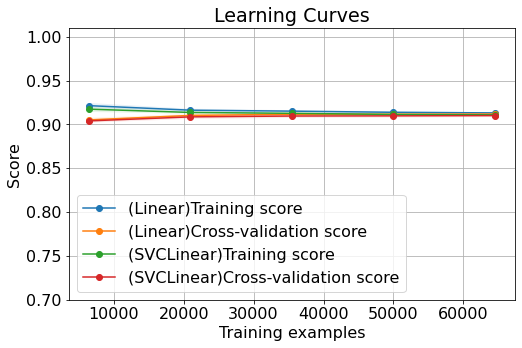

In [108]:
# SVC with linear kernel & LinearSVC
plot_learning_curves([linear_train_sizes, linearSVCclf_train_sizes], [linear_train_scores, linearSVCclf_train_scores],
                     [linear_test_scores, linearSVCclf_test_scores], ["Linear", "SVCLinear"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


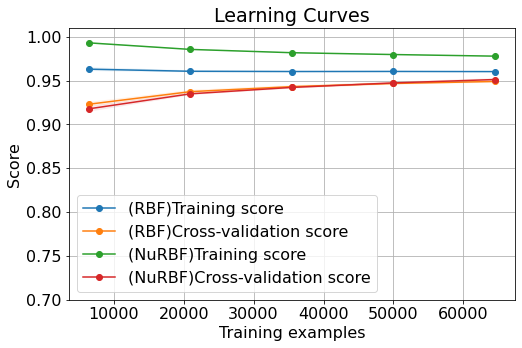

In [109]:
# SVC with RBF kernel & NuSVC with RBF kernel
plot_learning_curves([rbfclf_train_sizes, nurbfclf_train_sizes], [rbfclf_train_scores, nurbfclf_train_scores],
                     [rbfclf_test_scores, nurbfclf_test_scores], ["RBF", "NuRBF"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


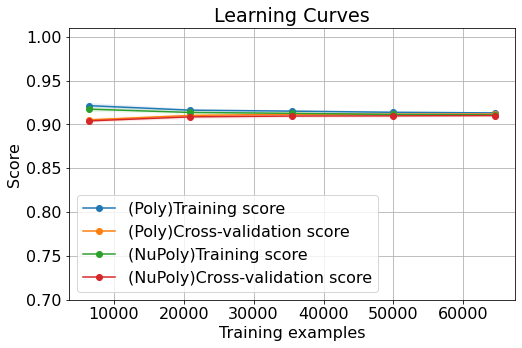

In [110]:
# SVC with Poly kernel & NuSVC with Poly kernel
polyclf_train_sizes, polyclf_train_scores, polyclf_test_scores
nupolyclf_train_sizes, nupolyclf_train_scores, nupolyclf_test_scores
plot_learning_curves([linear_train_sizes, linearSVCclf_train_sizes], [linear_train_scores, linearSVCclf_train_scores],
                     [linear_test_scores, linearSVCclf_test_scores], ["Poly", "NuPoly"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


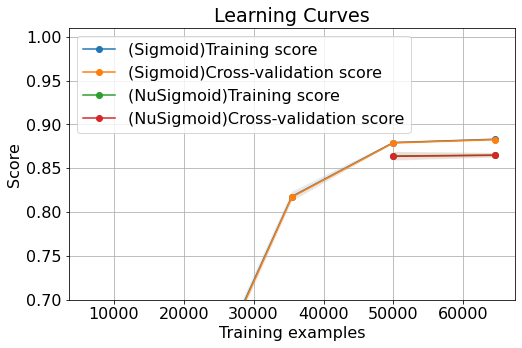

In [111]:
# SVC with Sigmoid kernel & NuSVC with Sigmoid kernel
plot_learning_curves([sigmoidclf_train_sizes, nusigmoidclf_train_sizes], [sigmoidclf_train_scores, nusigmoidclf_train_scores],
                     [sigmoidclf_test_scores, nusigmoidclf_test_scores], ["Sigmoid", "NuSigmoid"], 'upper left')